In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import os

In [2]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
store_ele = pd.HDFStore("output_PU_clusters_check_ele_v4.2.h5")
dfele = store_ele['df']
df =dfele

In [58]:
store_gamma = pd.HDFStore("output_PU_clusters_check_gamma_v4.h5")
dfgam = store_gamma['df']
df = dfgam

In [59]:
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/simfraction_gamma"
os.makedirs(outputdir, exist_ok=True)

# Resolution study

Let's study the best threshold for resolution

In [62]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [63]:
seed = df[(df.is_seed==1)][['wi','en','eta','et', 'simfrac_sig']]
seed.columns = ['wi','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("wi"), on='wi')

In [64]:
# etas = [0,0.4,0.6,0.8,1.2,1.44, 1.57, 1.65, 1.75,2,2.25,2.5, 3]
etas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.479, 1.75, 2.0 ,2.25 ,3.0]
# ets =  [0,2,4,6,8,10,20,30,40,50,60,80,100]
ets = [ 0,2,3,4,5,6,7,8,9,10]
# thres = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 ,0.09 ,0.1 ,
#          0.15 ,0.20 ,0.25 ,0.30 ,0.40 ,0.50, 0.60 ,0.70, 0.80]
thres = np.logspace(-4,0,40)
    
res= []
# res_all = []

dfb = dfa[(dfa.seed_simfrac_sig > 0.01) & (dfa.in_window)]

for thr in thres:
    #print("DNN threshold: ", thr)
    g = dfb[(dfb.simfrac_sig >  thr) | (dfb.is_seed==1) ].groupby("wi", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_genen": "first", 
                         "calo_simen": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)                   
    scanres["thr"] = thr
    res.append(scanres)



res = pd.concat(res)


In [24]:
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

In [25]:
res

,eta_bin,et_bin,quantile_down,quantile_up,EoEtrue_68scale,EoEtrue_68width,EoEtrue_scale,EoEtrue_rms,rel_err,thr
0,0,0,0.380421,0.843422,0.631595,0.231501,0.729961,2.378314,0.033615,0.0001
1,1,0,0.444172,0.835599,0.649026,0.195713,0.662895,0.261707,0.033615,0.0001
2,2,0,0.419376,0.839381,0.642289,0.210003,0.658571,0.284895,0.032915,0.0001
3,3,0,0.452882,0.854091,0.665685,0.200605,0.684706,0.295310,0.033131,0.0001
4,4,0,0.348212,0.834362,0.631301,0.243075,0.625141,0.352897,0.028307,0.0001
...,...,...,...,...,...,...,...,...,...,...
4315,7,8,0.387588,0.740129,0.540508,0.176271,0.547940,0.179373,0.071429,1.0000
4316,8,8,0.420014,0.799410,0.601772,0.189698,0.599286,0.187487,0.040032,1.0000
4317,9,8,0.552056,0.906399,0.761113,0.177172,0.739021,0.177797,0.045129,1.0000
4318,10,8,0.718330,0.963285,0.860611,0.122477,0.841472,0.142855,0.045691,1.0000


## By Et and eta bin

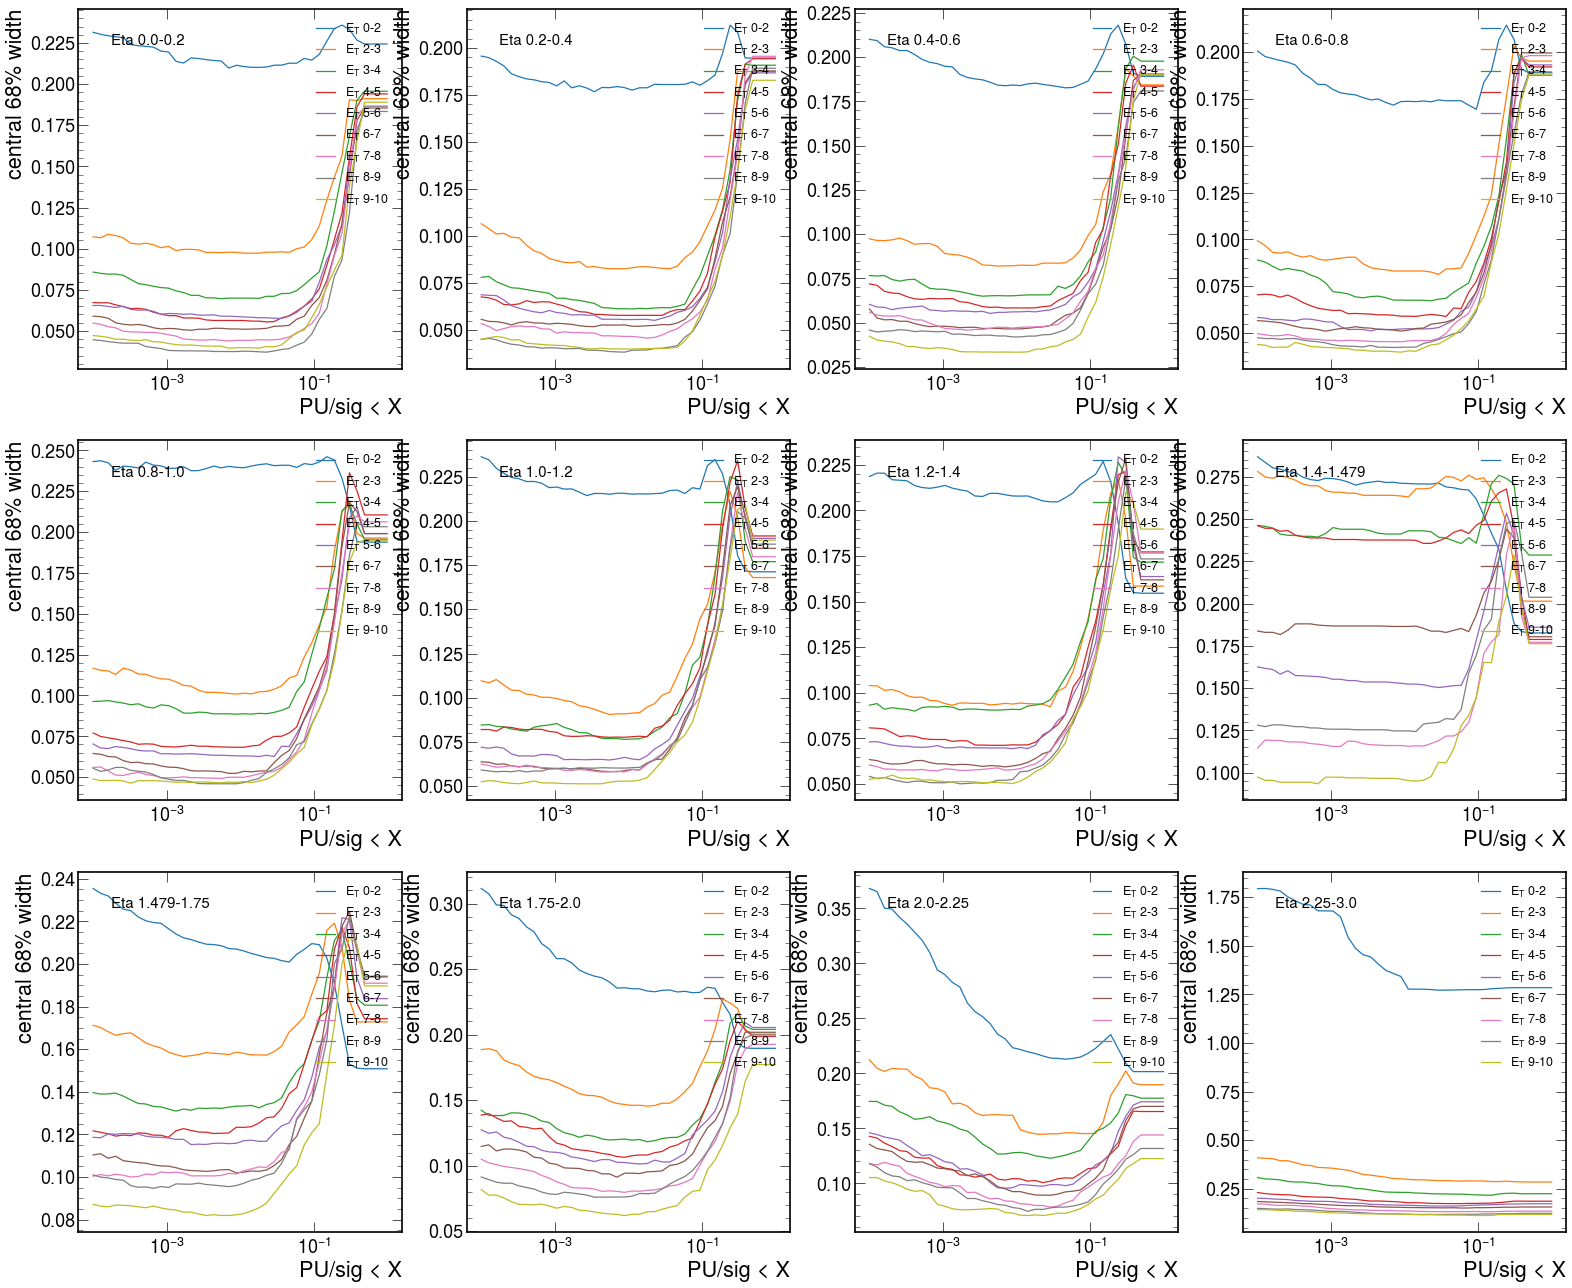

In [26]:
f, axs = plt.subplots(3,4, figsize=(32,27), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("PU/sig < X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")
    

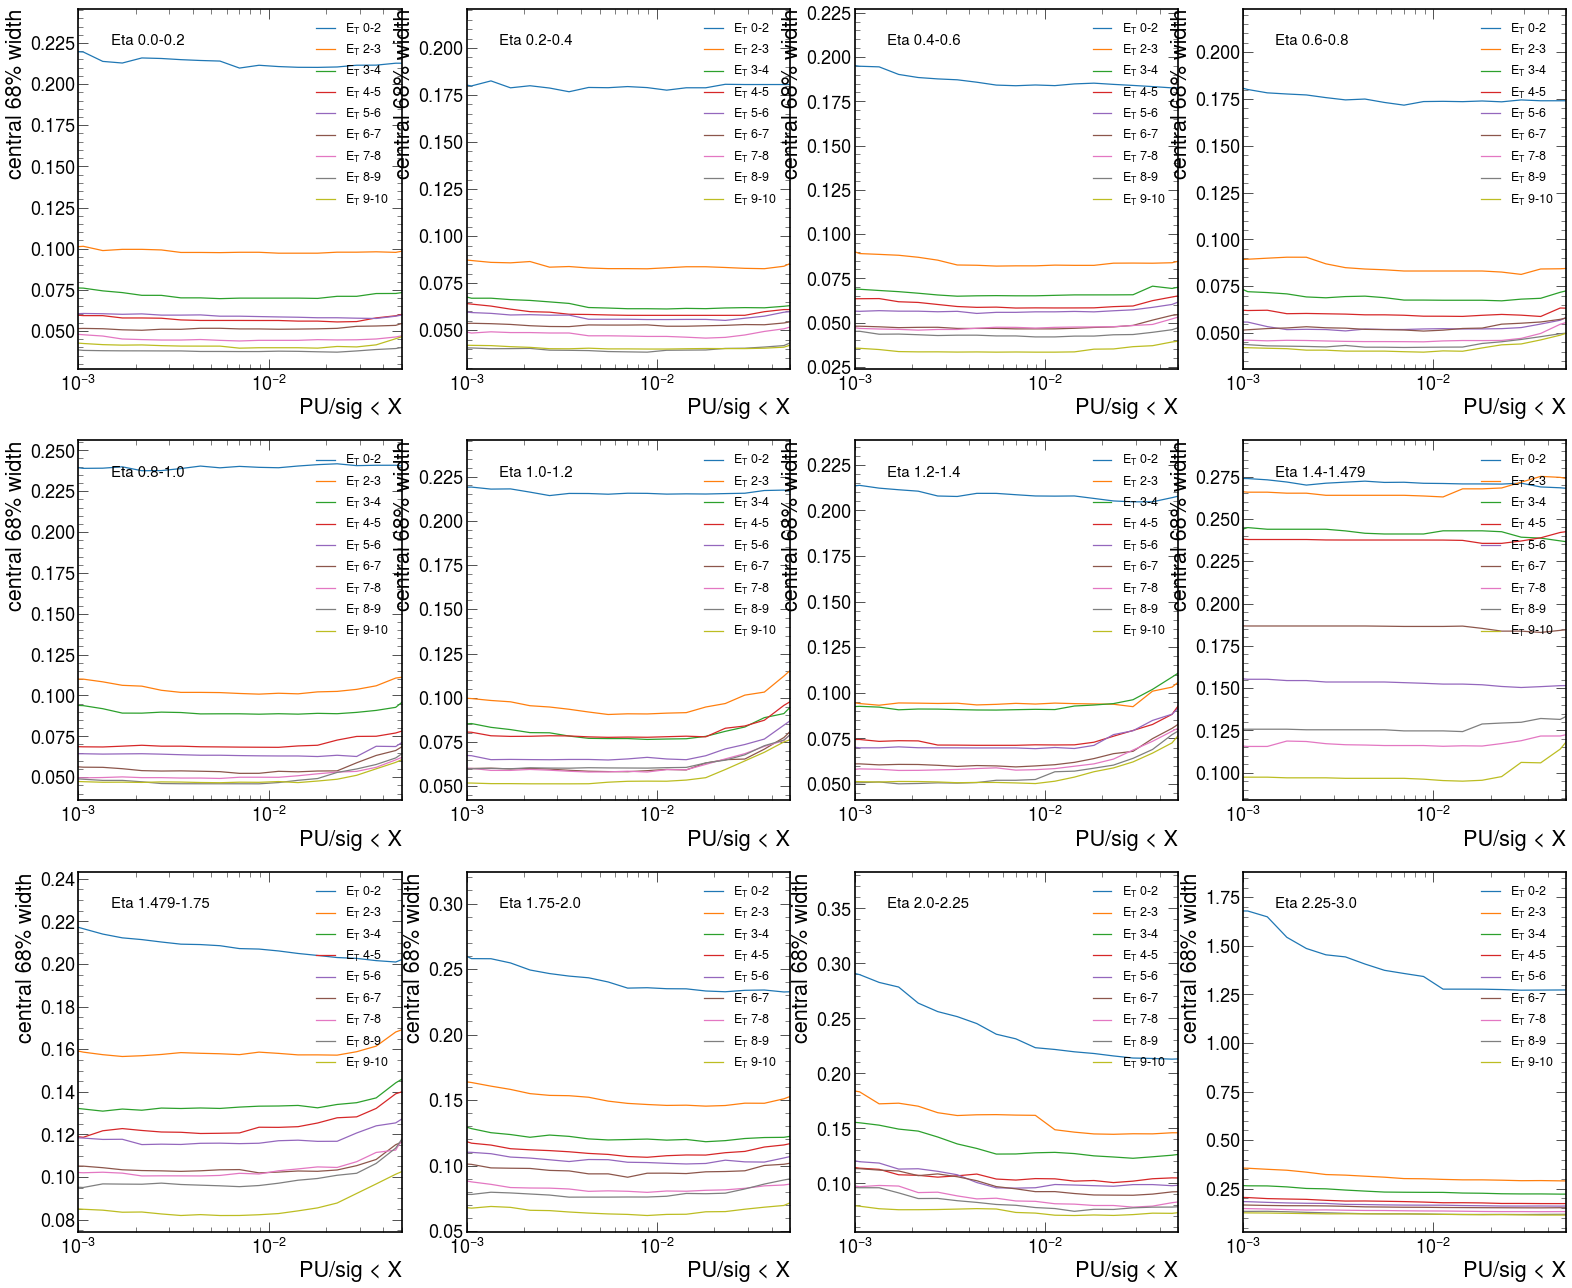

In [27]:
f, axs = plt.subplots(3,4, figsize=(32,27), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("PU/sig < X")
    ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")
    

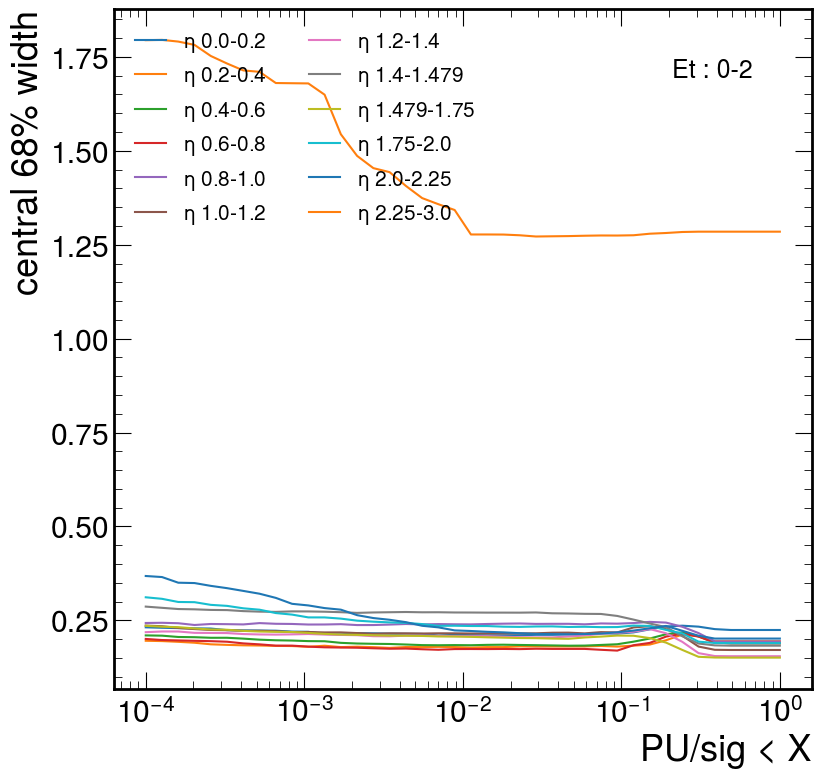

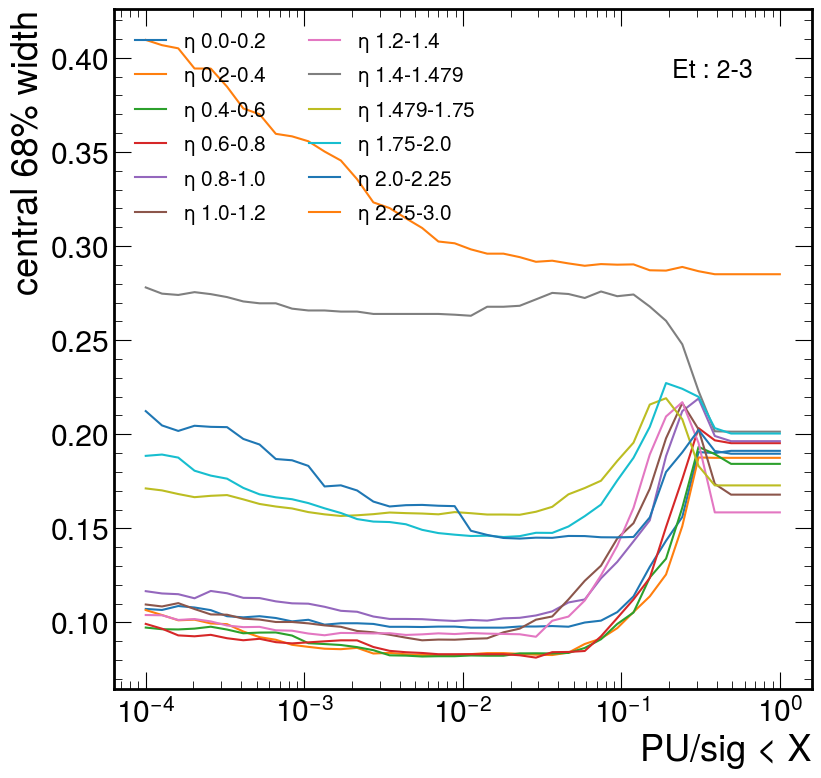

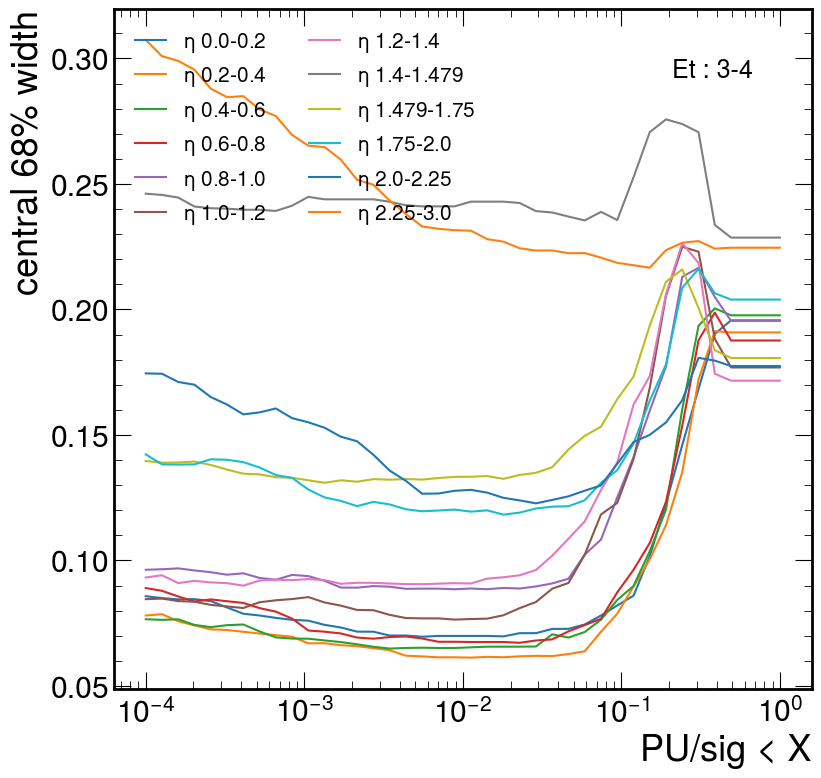

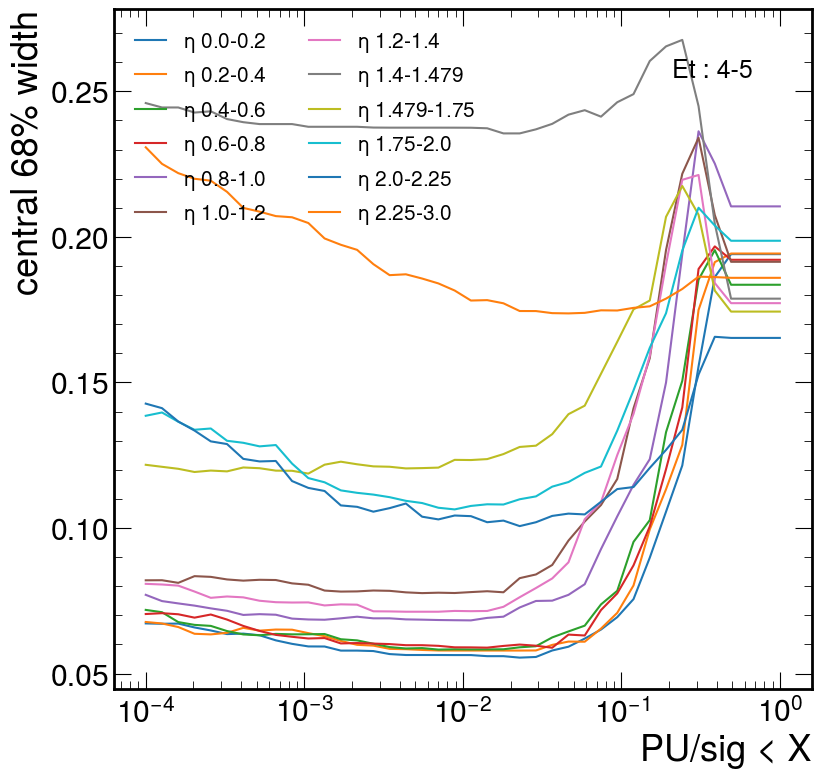

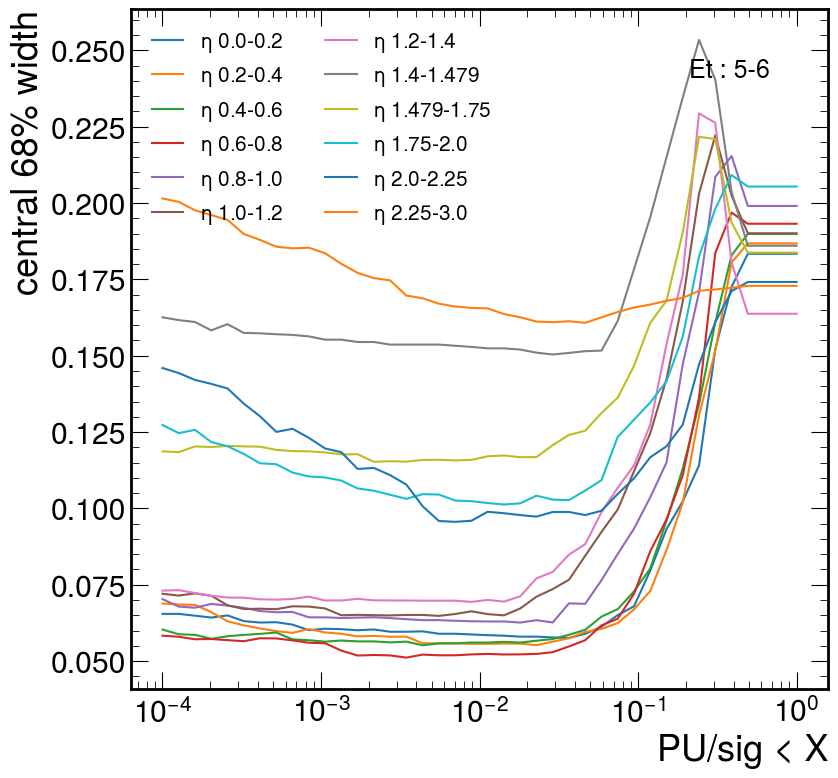

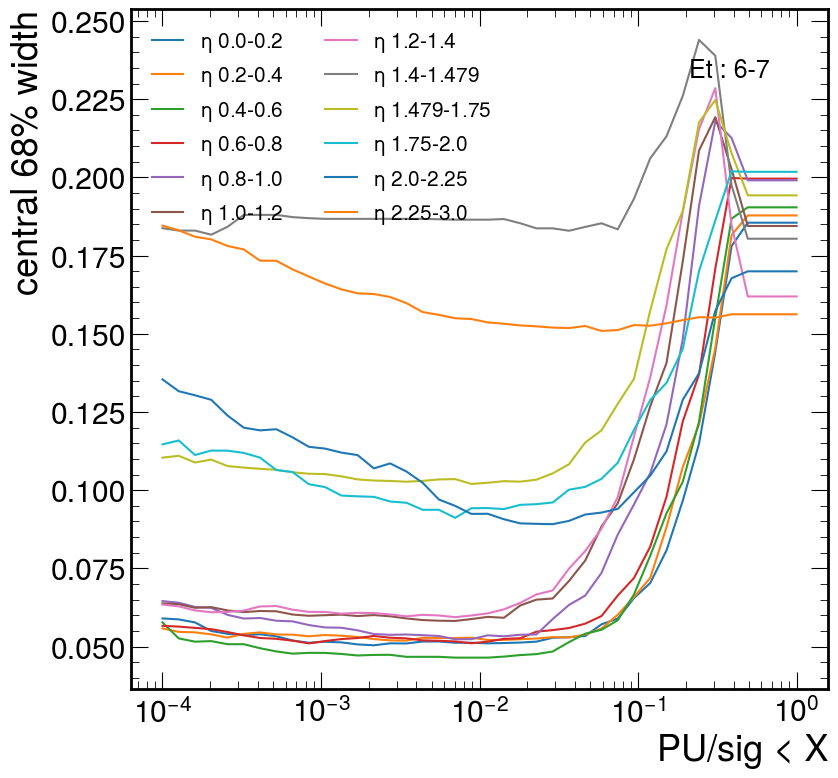

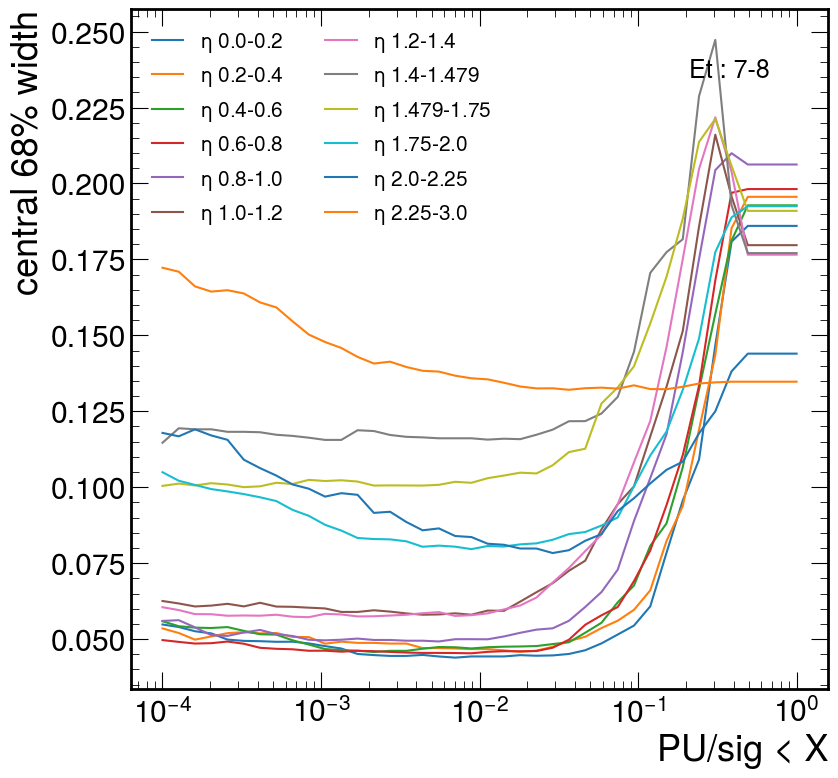

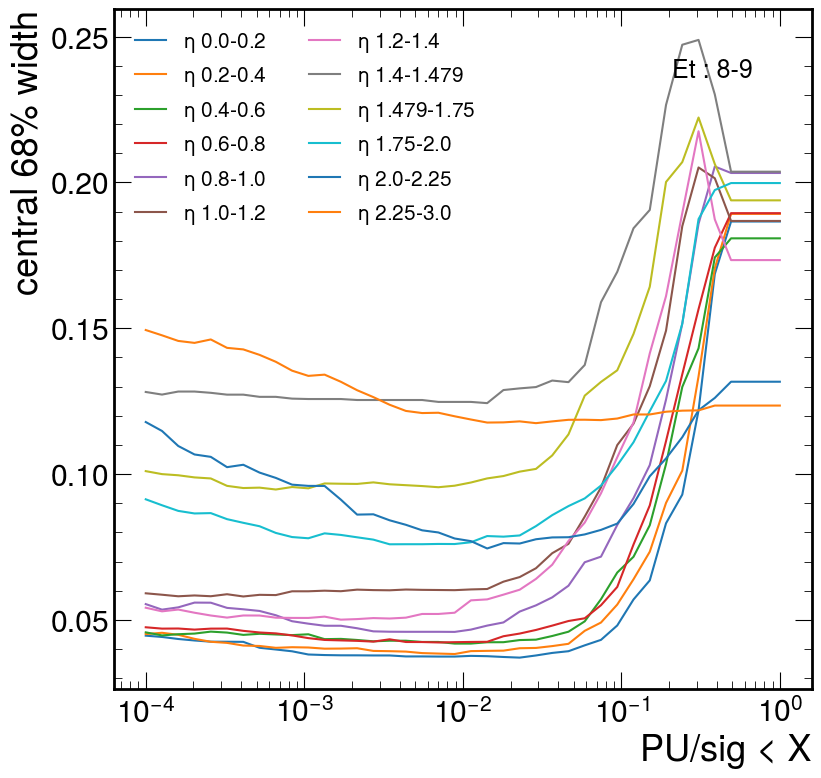

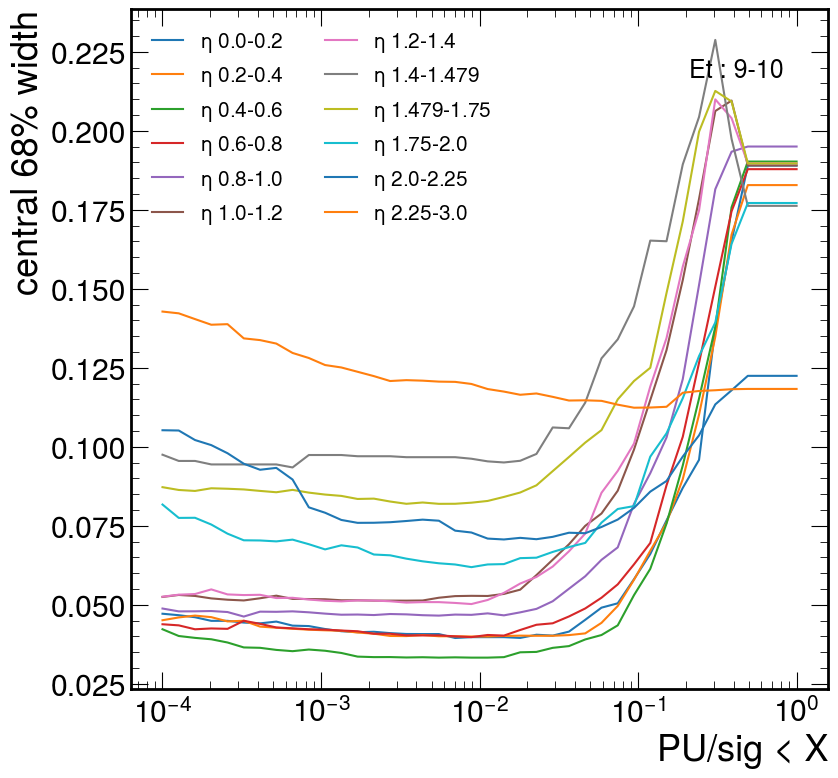

In [28]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.8,0.9, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("PU/sig < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_smallEt_{}_{}.png'.format(ets[iet],ets[iet+1]))

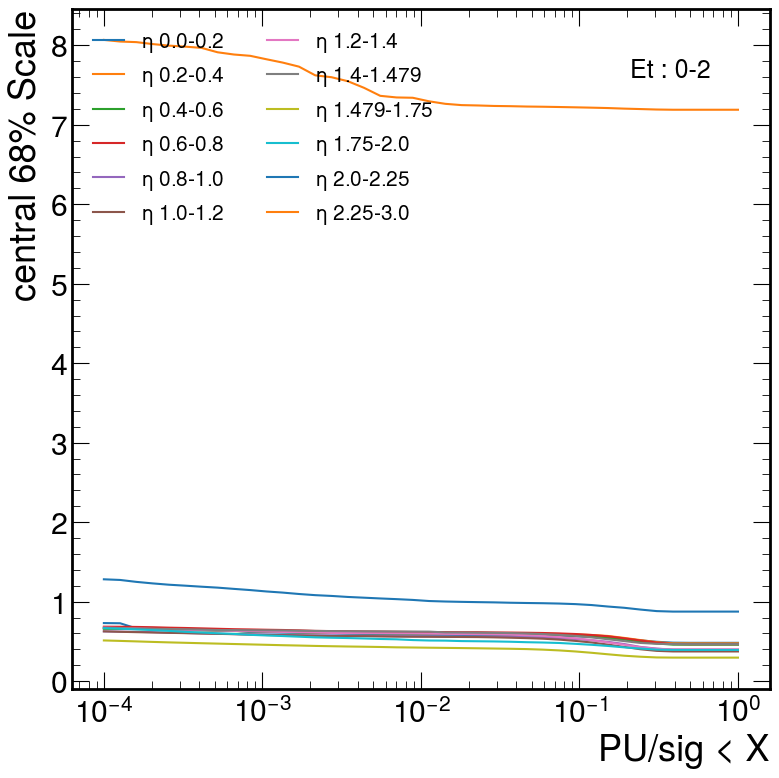

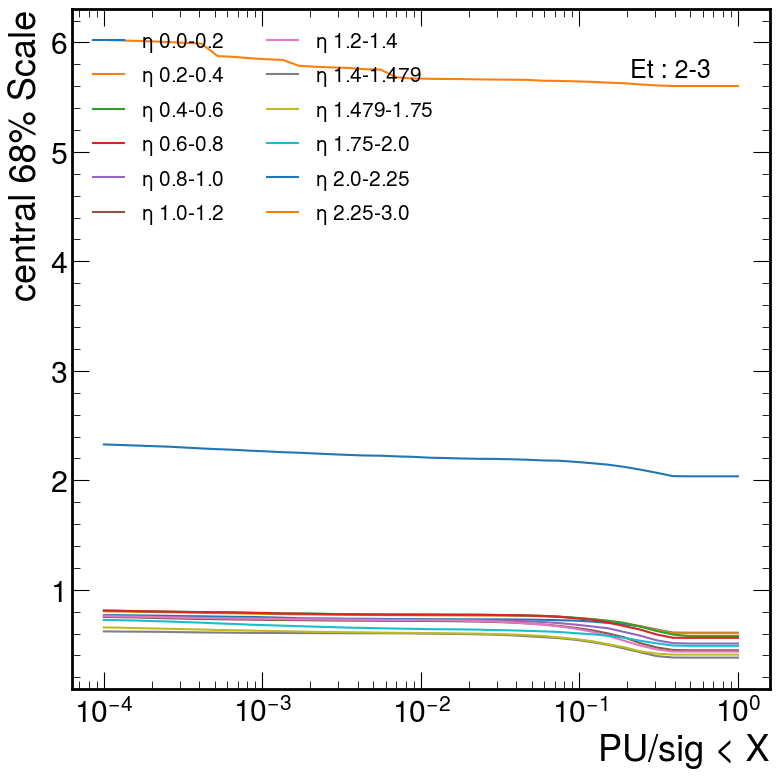

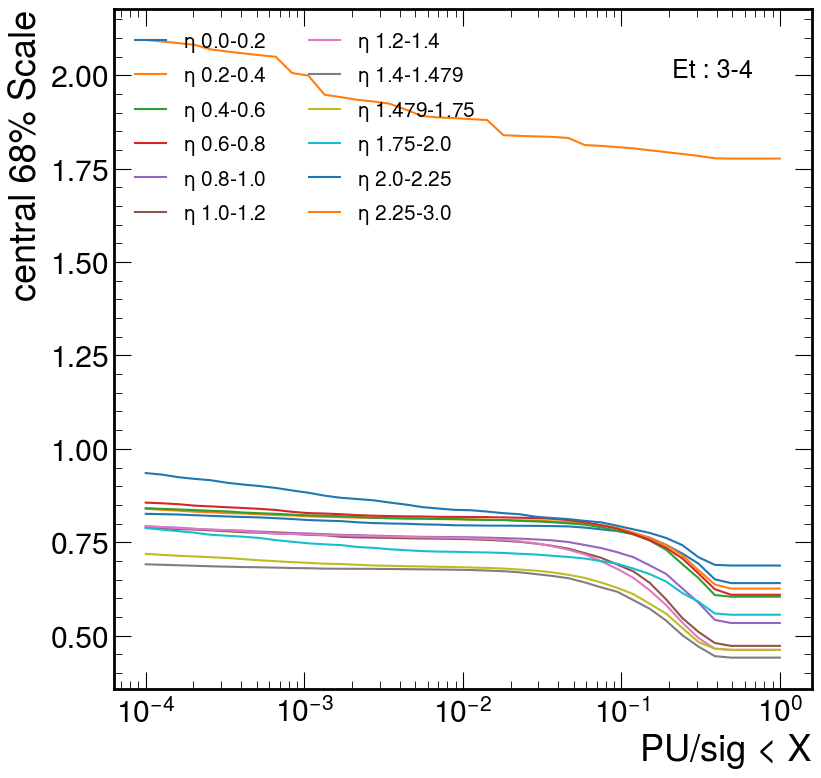

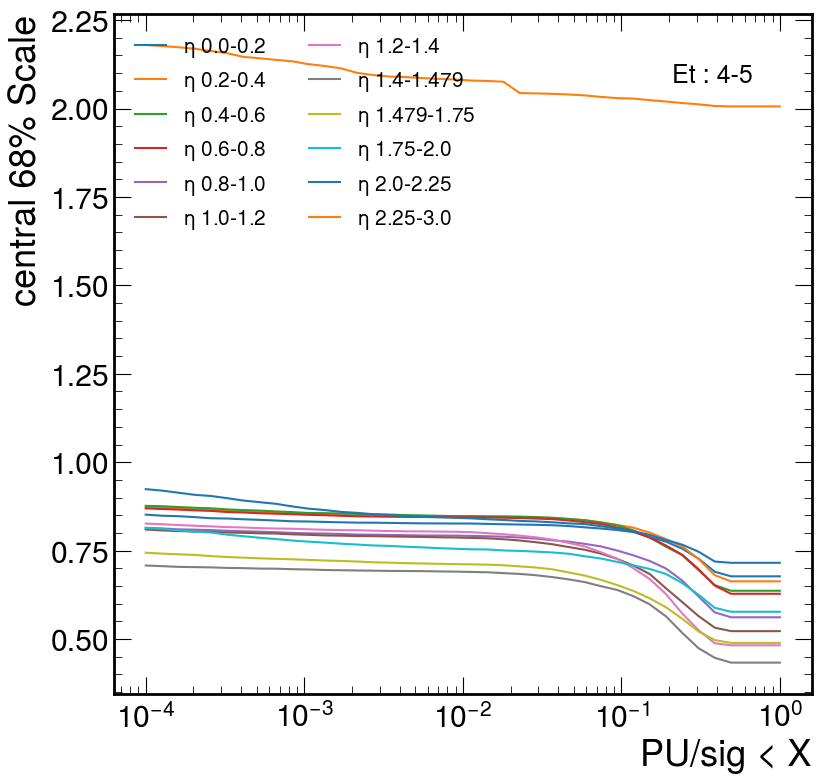

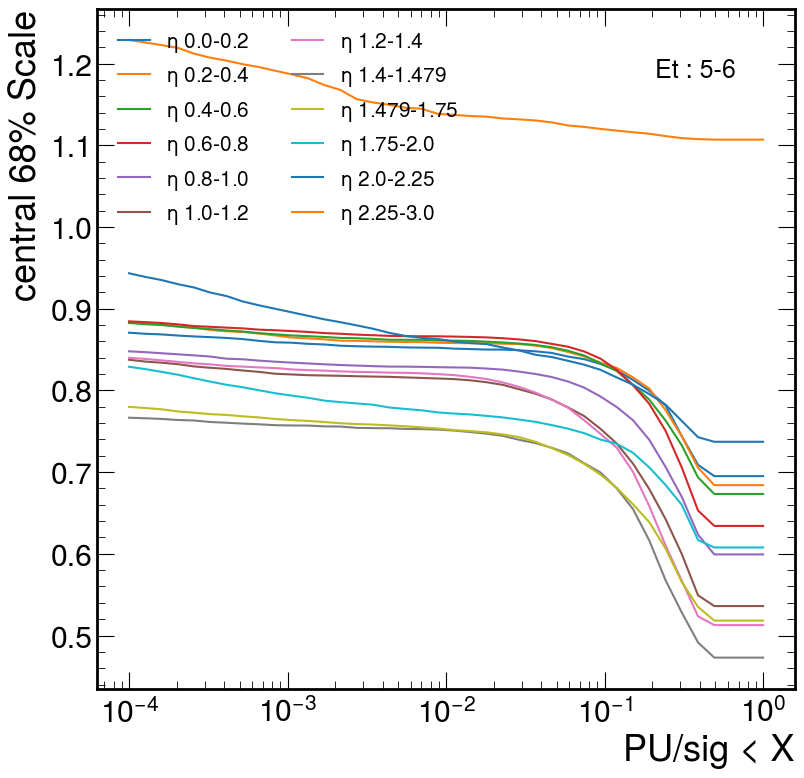

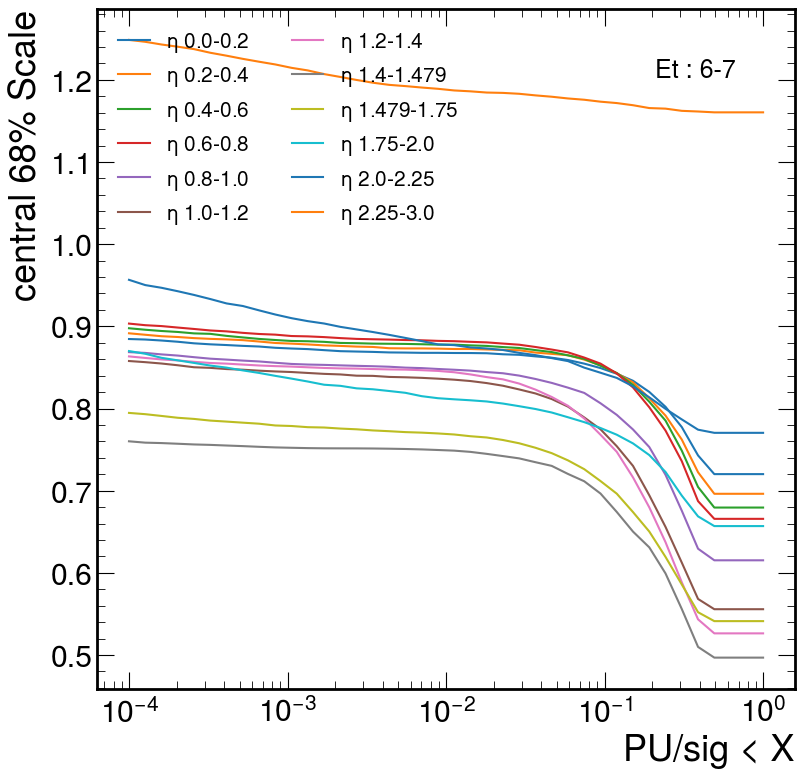

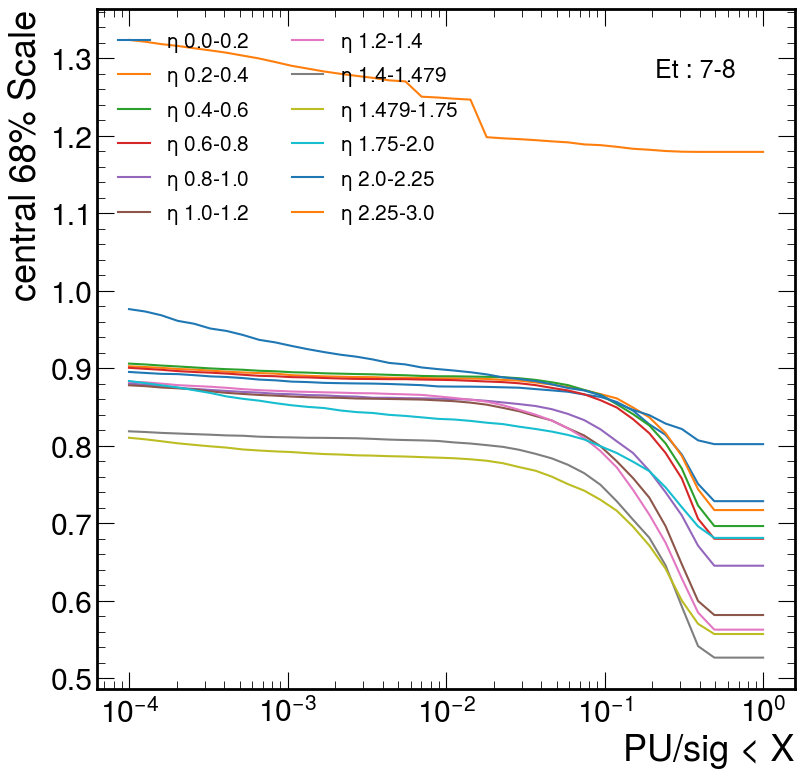

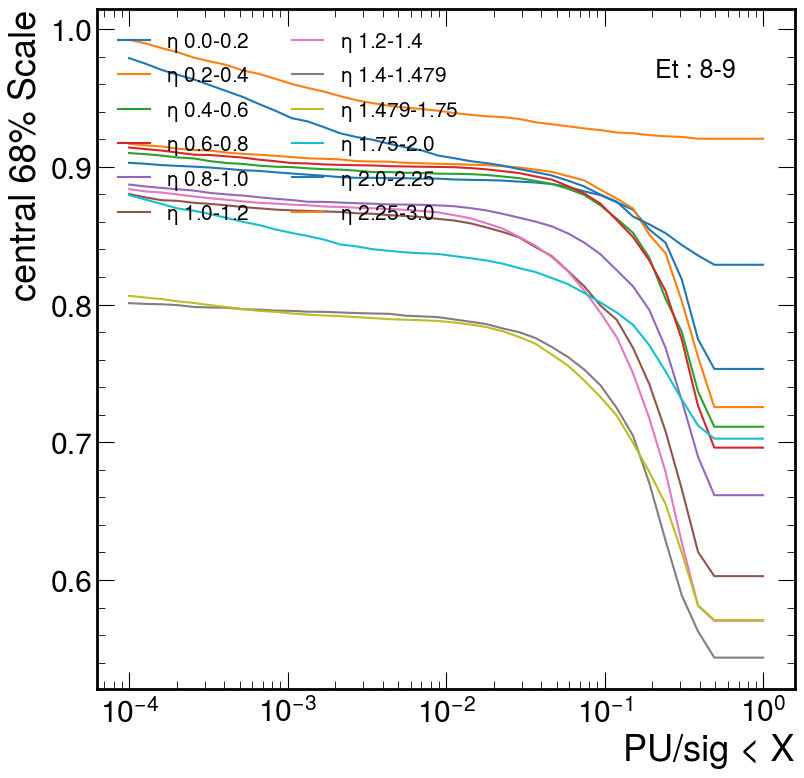

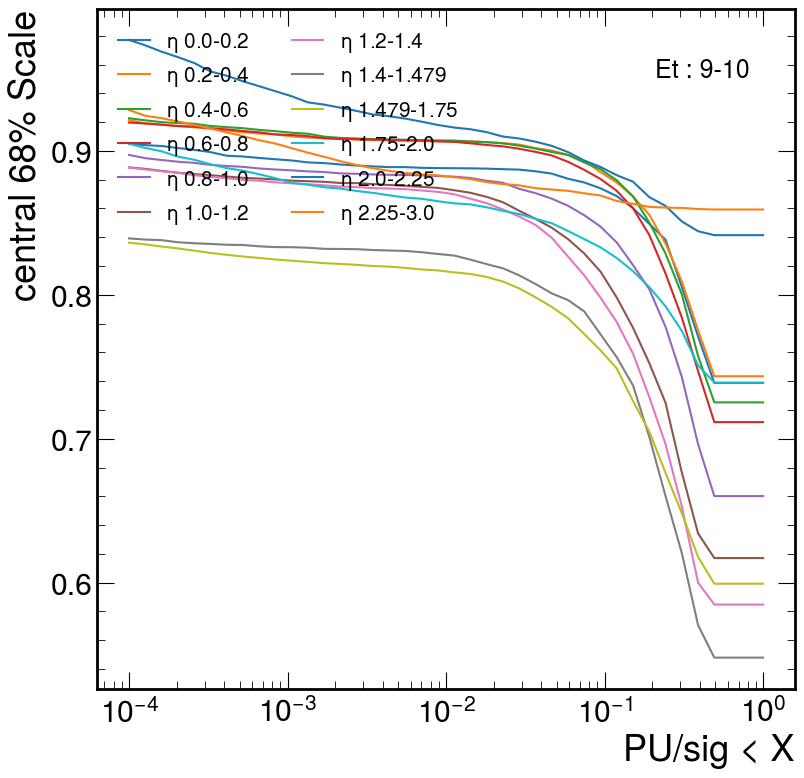

In [29]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.8,0.9, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("PU/sig < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_smallEt_{}_{}.png'.format(ets[iet],ets[iet+1]))

In [36]:
def bin_analysis(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis)

In [37]:
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [40]:
a

,eta_bin,et_bin,thr,scale,width
0,0,0,0.007017,0.209768,0.209768
1,1,0,0.003455,0.176751,0.176751
2,2,0,0.046416,0.182588,0.182588
3,3,0,0.094267,0.169528,0.169528
4,4,0,0.492388,0.193863,0.193863
...,...,...,...,...,...
103,7,8,0.000661,0.093487,0.093487
104,8,8,0.005541,0.081974,0.081974
105,9,8,0.008886,0.061940,0.061940
106,10,8,0.014251,0.070698,0.070698


In [51]:
ets

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]

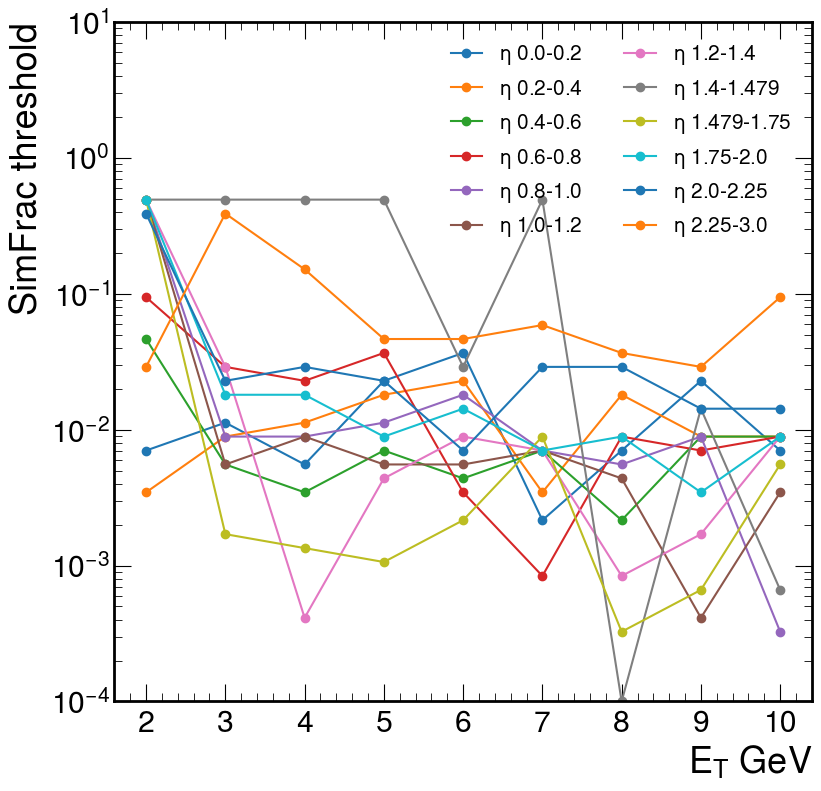

In [57]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker="o")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_smallEt_{}_{}.png'.format(ets[iet],ets[iet+1]))

Text(1, 0, '$\\eta$ bin')

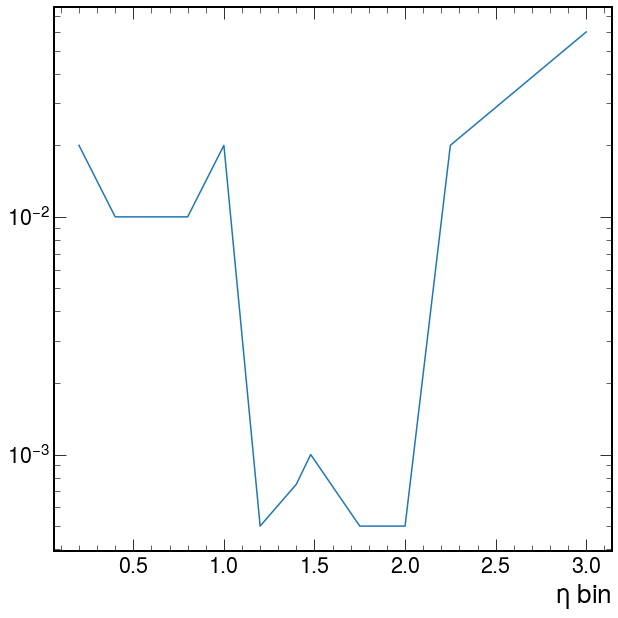

In [69]:
y = [0.019999999553,
0.00999999977648,
0.00999999977648,
0.00999999977648,
0.019999999553,
0.000500000023749,
0.000750000006519,
0.0010000000475,
0.000500000023749,
0.000500000023749,
0.019999999553,
0.0599999986589]

plt.plot(etas[1:], y )
plt.yscale("log")
plt.xlabel("$\eta$ bin")